# SIPRI Arms Transfers: Network Visualization

This notebook demonstrates how to:
1. **Load** the cleaned SIPRI arms transfer dataset.
2. **Construct** a directed graph using NetworkX (supplier → recipient).
3. **Analyze** basic network properties (e.g., in-degree, out-degree).
4. **Visualize** the network using both NetworkX’s built-in drawing and an interactive Plotly force-directed layout.

In [1]:
import pandas as pd
import networkx as nx
import math
import plotly.express as px
import plotly.graph_objects as go

# If needed, install packages:
# !pip install networkx plotly


## 1. Load the Cleaned SIPRI Data

Replace `cleaned_sipri_data.csv` with the actual filename of your cleaned dataset. Make sure columns like `Supplier ISO`, `Recipient ISO`, `Number delivered`, `SIPRI TIV`, etc., match what’s in your CSV.

In [2]:
# Load the dataset
df = pd.read_csv('../data/sipri_trade_data_tidy.csv')
print("Number of rows in dataset:", len(df))
df.head()

Number of rows in dataset: 29519


,Recipient,Supplier,Year of order,Uncertainty flag order year,Number ordered,Uncertainty flag number ordered,Weapon designation,Weapon description,Number delivered,Uncertainty flag number delivered,Year(s) of delivery,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons,Recipient ISO,Supplier ISO,Delivery Year Numeric,Median Year of Delivery
0,Afghanistan,Brazil,2017.0,0.0,6.0,0,EMB-314 Super Tucano,trainer/combat aircraft,6.0,0,2018,New,A-29B version; financed by USA; ordered via US...,4.50,27.0,27.0,AFG,BRA,2018.0,1988
1,Afghanistan,Soviet Union,1987.0,1.0,3.0,0,An-26,transport aircraft,3.0,0,1987,New,NaN,8.50,25.5,25.5,AFG,NaN,1987.0,1988
2,Afghanistan,Soviet Union,1988.0,1.0,40.0,1,2S9 120mm,self-propelled gun,40.0,0,1988,Second hand,Second-hand; aid; handed over by Soviet forces...,0.30,12.0,12.0,AFG,NaN,1988.0,1988
3,Afghanistan,Soviet Union,1979.0,1.0,6000.0,1,Malyutka,anti-tank missile,6000.0,0,1979; 1980; 1981; 1982; 1983; 1984; 1985; 1986...,New,Incl for Mi-24 helicopters and BMP-1 IFV,0.01,60.0,60.0,AFG,NaN,1979.0,1988
4,Afghanistan,Soviet Union,1988.0,1.0,13.0,1,9P113,surface-to-surface missile launcher,13.0,0,1988,Second hand,Second-hand,0.20,2.6,2.6,AFG,NaN,1988.0,1988


## 2. Construct a Directed Graph

We’ll create a directed graph (`DiGraph`) where each node is a country (identified by its ISO code), and each edge represents an arms transfer from `Supplier ISO` to `Recipient ISO`. We’ll use the `Number delivered` (or `SIPRI TIV`) as the weight of the edge.

In [3]:
# Create a directed graph
G = nx.DiGraph()

# Iterate over rows to add edges
# Adjust column names if needed
for idx, row in df.iterrows():
    supplier = row['Supplier ISO']
    recipient = row['Recipient ISO']
    if pd.isna(supplier) or pd.isna(recipient):
        continue  # skip rows with missing ISO codes
    
    # Use number delivered as the weight (or sipri_tiv)
    weight = row.get('Number delivered', 1)
    if pd.isna(weight):
        weight = 1

    # Add edge to the graph
    if G.has_edge(supplier, recipient):
        # If edge already exists, accumulate the weight
        G[supplier][recipient]['weight'] += weight
    else:
        G.add_edge(supplier, recipient, weight=weight)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 173
Number of edges: 2342


## 3. Basic Network Analysis

We can compute simple statistics, such as the in-degree and out-degree of each node (how many countries each node imports from vs. exports to).

In [4]:
# Compute in-degree and out-degree
in_degs = dict(G.in_degree(weight='weight'))   # Weighted in-degree
out_degs = dict(G.out_degree(weight='weight')) # Weighted out-degree

# Convert to DataFrame for easier inspection
degree_df = pd.DataFrame({
    'ISO': list(in_degs.keys()),
    'InDegree': [in_degs[n] for n in in_degs.keys()],
    'OutDegree': [out_degs[n] for n in out_degs.keys()]
})

# Sort by highest InDegree (top importers)
top_importers = degree_df.sort_values('InDegree', ascending=False).head(10)
# Sort by highest OutDegree (top exporters)
top_exporters = degree_df.sort_values('OutDegree', ascending=False).head(10)

print("Top 10 Importers (by total deliveries):\n", top_importers)
print("\nTop 10 Exporters (by total deliveries):\n", top_exporters)

Top 10 Importers (by total deliveries):
      ISO  InDegree  OutDegree
107  SAU  167050.0      184.0
10   UKR  135397.0    22230.0
16   DEU  120648.0   166008.0
11   GBR  118688.0   113372.0
3    USA  109707.0  1201885.0
13   ITA  103925.0    21059.0
36   ISR   91193.0    64695.0
6    IND   89423.0      860.0
62   IRN   84927.0     1331.0
52   PAK   82609.0     1197.0

Top 10 Exporters (by total deliveries):
     ISO  InDegree  OutDegree
3   USA  109707.0  1201885.0
15  FRA   22375.0   368269.0
16  DEU  120648.0   166008.0
11  GBR  118688.0   113372.0
4   CHN   17179.0    99520.0
36  ISR   91193.0    64695.0
19  SWE   24036.0    35126.0
10  UKR  135397.0    22230.0
13  ITA  103925.0    21059.0
2   CAN   41809.0    19310.0


## 4. Simple Network Visualization with NetworkX

NetworkX’s built-in `draw` methods are good for quick looks, but they may struggle with large networks. If your network is huge, consider subsetting or using an interactive library like Plotly or D3.js.

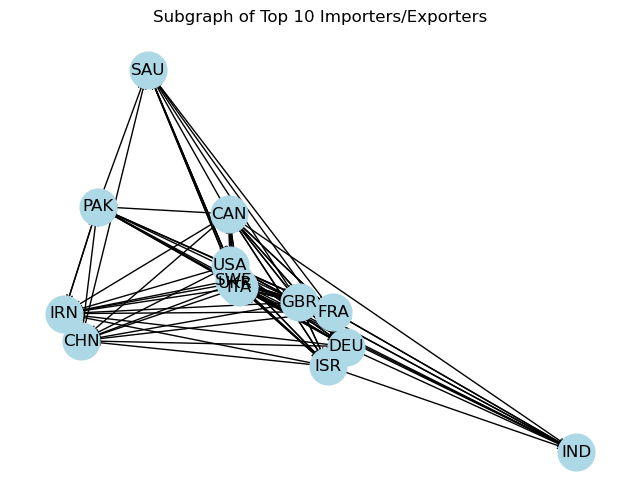

In [5]:
import matplotlib.pyplot as plt

# For demonstration, create a subgraph of top exporters/importers to keep it small.
top_nodes = set(top_importers['ISO']).union(set(top_exporters['ISO']))
subG = G.subgraph(top_nodes)

# Draw the subgraph with spring layout
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subG, k=0.35, seed=42)
nx.draw_networkx_nodes(subG, pos, node_size=700, node_color='lightblue')
nx.draw_networkx_labels(subG, pos)
nx.draw_networkx_edges(subG, pos, arrows=True, arrowstyle='->')

plt.title("Subgraph of Top 10 Importers/Exporters")
plt.axis('off')
plt.show()

## 5. Interactive Force-Directed Graph with Plotly

Plotly can create interactive visualizations in a Jupyter environment. We'll convert our graph to a format Plotly can understand and draw a force-directed layout. This is more advanced, but it’s great for exploring networks.

In [7]:
# We'll continue using subG for demonstration. For a full network, replace subG with G.
edges_x = []
edges_y = []
pos = nx.spring_layout(subG, k=0.35, seed=42)

for edge in subG.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edges_x.append(x0)
    edges_x.append(x1)
    edges_x.append(None)
    edges_y.append(y0)
    edges_y.append(y1)
    edges_y.append(None)

# Create edge traces
edge_trace = go.Scatter(
    x=edges_x, y=edges_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node traces
nodes_x = []
nodes_y = []
labels = []
for node in subG.nodes():
    x, y = pos[node]
    nodes_x.append(x)
    nodes_y.append(y)
    labels.append(node)

node_trace = go.Scatter(
    x=nodes_x, y=nodes_y,
    mode='markers+text',
    text=labels,
    textposition='top center',
    marker=dict(
        showscale=False,
        color='lightblue',
        size=15,
        line_width=2
    ),
    hoverinfo='text'
)

# Combine edge_trace and node_trace in a Plotly Figure
fig = go.Figure(data=[edge_trace, node_trace],
               layout=go.Layout(
                   title='<br>Interactive Force-Directed Graph',
                   title_x=0.5,
                   showlegend=False,
                   hovermode='closest',
                   margin=dict(b=20,l=5,r=5,t=40),
                   xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                   yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
               ))

fig.show()

## Conclusion
You now have a notebook that:
1. Loads your cleaned SIPRI data.
2. Builds a directed graph in NetworkX.
3. Performs basic network analysis.
4. Visualizes the subgraph of top nodes with both NetworkX’s simple layout and Plotly’s interactive force-directed layout.

Feel free to adjust column names, add filters (e.g., by year), or refine the weighting logic to suit your analysis goals.